In [2]:
from tqdm import tqdm
from keras.datasets import mnist, cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Flatten, Dropout, BatchNormalization, MaxPool2D, Activation, AveragePooling2D
from keras.layers import ZeroPadding2D

from keras.optimizers import SGD, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.callbacks import EarlyStopping
import numpy as np

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

import math
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300
matplotlib.rcParams['text.usetex'] = True


## Define our models

In [3]:
def load_dataset_mnist():
    (trainX, trainY), (testX, testY) = mnist.load_data()
    return trainX.reshape((trainX.shape[0], 28, 28, 1)), \
            to_categorical(trainY), \
            testX.reshape((testX.shape[0], 28, 28, 1)), \
            to_categorical(testY)

def load_dataset_cifar10():
    (trainX, trainY), (testX, testY) = cifar10.load_data()
    return trainX.reshape((trainX.shape[0], 32, 32, 3)), \
        to_categorical(trainY), \
        testX.reshape((testX.shape[0], 32, 32, 3)), \
        to_categorical(testY)

def prep_pixels(train, test):
    return train.astype('float32') / 255.0, test.astype('float32') / 255.0

def square_activation(x):
    return K.square(x)

def identity(x):
    return x

In [4]:
def conv_weights(d_in, W_c, s, padding='valid', pool=False):
    '''
    obtain weights from kernel, equivalent to Dense(c_in * d_in ** 2, c_out * d_out ** 2),
    expect W_c to be of shape (c_out, c_in, k, k)
    '''
    c_in = W_c.shape[1]
    c_out = W_c.shape[0]
    k = W_c.shape[-1]
    p = None
    if padding == 'valid':
        p = 0
        d_out = int(math.floor((d_in - k + p) / s)) + 1
    elif padding == 'same':
        d_out = math.ceil(d_in / s)

        if d_in % s == 0:
            p = max(k - s, 0)
        else:
            p = max(k - (d_in % s), 0)
                                                
    W = np.zeros((c_out * d_out ** 2, c_in * d_in ** 2))

    # iterate through each output
    for j in tqdm(range(c_out * d_out * d_out)):
        c_o = j // (d_out * d_out)
        y_o = j % (d_out * d_out) // d_out
        x_o = j % (d_out * d_out) % d_out

        # iterate through each weight of the filter for c_o
        for i in range(c_in * k * k):
            c_i = i // (k * k)
            k_r = (i % (k * k)) // k
            k_c = i % (k * k) % k

            w = W_c[c_o, c_i, k_r, k_c]

            # find the position of the input value that contributes to output j, under weight w.
            pad_offset = p // 2
            y = y_o * s + k_r - pad_offset
            x = x_o * s + k_c - pad_offset

            # out-of-bounds, could happen due to padding
            if y >= d_in or x >= d_in or y < 0 or x < 0:
                continue

            # tune average pooling values
            if w != 0 and pool:
                t = k ** 2
                
                x_ = x - k_c
                y_ = y - k_r
                
                p_x = k * max(
                            max(0, -x_),
                            max(0, x_ + k - d_in)
                )
                
                p_y = k * max(
                            max(0, -y_),
                            max(0, y_ + k - d_in)
                )
                
                t -= p_x + p_y - (p_x // k) * (p_y // k)
                
                w = 1 / t

            W[j][c_i * d_in ** 2 + y * d_in + x] = w

    return W

def conv_biases(d_in, W_c, biases, s, padding='valid'):
    c_out = W_c.shape[0]
    k = W_c.shape[-1]
    if padding == 'valid':
        d_out = int(math.floor((d_in - k) / s)) + 1
    elif padding == 'same':
        d_out = math.ceil(d_in / s)

    b = np.zeros(shape=(c_out, d_out, d_out))

    for c_o in range(c_out):
        b[c_o] = np.ones(shape=(d_out, d_out)) * biases[c_o]

    return b.flatten()


def avg_pool_weights(c_in, k):
    W = np.zeros(shape=(c_in, c_in, k, k))

    for c_i in range(c_in):
        W[c_i, c_i] = np.ones(shape=(k, k)) * (1 / (k ** 2))

    return W


def dense_weights(weights, c_in):
    new_weights = []
    for k in range(c_in):
        for i in range(weights.shape[0] // c_in):
            new_weights.append(weights[i * c_in + k])
            
    
    new_weights = np.array(new_weights)
    return new_weights

def dense_weights_reverse(weights, c_in):
    new_weights = []
    for k in range(weights.shape[0] // c_in):
        for i in range(c_in):
            new_weights.append(weights[k * c_in + i])
        
    new_weights = np.array(new_weights)
    return new_weights

def large_matmul(mat1, mat2, chunks=10):
    result = None
    width = mat2.shape[1] // chunks
    for i in range(chunks):
        print(i)
        
        mat2_chunk = mat2[:, i * width: (i + 1) * width]
        result_chunk = np.matmul(mat1, mat2_chunk)

        if result is None:
            result = result_chunk
        else:
            result = np.concatenate((result, result_chunk), axis=1)
    return result

In [5]:
from keras.layers import Permute

def save_keras_weights(model, path, linear):
    w = [[None, None]]

    flatten = False
    channels_last = 1

    for i, layer in enumerate(model.layers):
        in_lin = False
        for W, b, j_s, j_e, f in linear:
            if i == j_s:
                if f:
                    w.append([None, None])
                w.append([W, b])
            if j_s <= i < j_e:
                in_lin = True
        if in_lin:
            continue
            
        if layer.name.startswith('zero_padding'):
            continue
            
        if layer.name.startswith('permute'):
            continue
            
        if layer.name.startswith('dropout'):
            continue
            
        if layer.name.startswith('activation'):
            w.append([None, None])
            continue

        if layer.name.startswith('conv2d'):
            w.append([layer.weights[0].numpy(), layer.weights[1].numpy()])
            channels_last = layer.weights[0].shape[-1]
            continue

        if layer.name.startswith('flatten'):
            w.append([None, None])
            flatten = True
            continue

        if layer.name.startswith('dense'):
            if flatten:
                w.append([dense_weights(layer.weights[0].numpy(), channels_last),
                          layer.weights[1].numpy()])
                flatten = False
            else:
                w.append([layer.weights[0].numpy(), layer.weights[1].numpy()])

    w = np.array(w, dtype=object)

    print(w.shape)

    np.save(path, w)

def save_data(model, name, linear):
    # linear = [(W, b, i, j)]
    
    preds = model.predict(testX)
    pred_labs = []
    for v in preds:
        pred_labs.append(np.argmax(v))

    np.save('data/' + name + '_preds.npy', np.array(pred_labs))
    np.save('data/' + name + '_outs.npy', np.array(preds))
    np.save('data/' + name + '_testX.npy', testX)

    save_keras_weights(model, 'data/' + name + '_weights.npy', linear)

In [6]:
def mnist_cryptonets(activation=square_activation):
    model = Sequential()
    model.add(ZeroPadding2D(padding=(1, 1), input_shape=(28, 28, 1)))
    model.add(Conv2D(5, (5, 5), strides=2, padding='valid'))
    model.add(Activation(activation))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=1, padding='same'))
    model.add(Conv2D(50, (5, 5), strides=2, padding='valid'))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=1, padding='same'))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Activation(activation))
    model.add(Dense(10, activation='sigmoid'))

    opt = Adam(lr=0.0005)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def mnist_tiny():
    model = Sequential()
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(Conv2D(5, (5, 5), strides=2, padding='valid'))
    model.add(Activation(activation))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=1, padding='same'))
    model.add(Conv2D(50, (5, 5), strides=2, padding='valid'))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=1, padding='same'))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Activation(activation))
    model.add(Dense(10, activation='sigmoid'))

    opt = SGD(lr=0.0005)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def mnist_opt(activation=square_activation):
    model = Sequential()
    model.add(ZeroPadding2D(padding=(1, 1), input_shape=(28, 28, 1)))
    model.add(Conv2D(5, (3, 3), strides=1, padding='valid'))
    model.add(Activation(activation))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=2, padding='same'))
    model.add(Conv2D(50, (3, 3), strides=1, padding='valid'))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=1, padding='same'))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(Activation(activation))
    model.add(Dense(10, activation='sigmoid'))

    #opt = Adam(lr=0.0003)
    opt = Adam(lr=0.00004)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def mnist_opt_bn(activation=square_activation):
    model = Sequential()
    model.add(ZeroPadding2D(padding=(1, 1), input_shape=(28, 28, 1)))
    model.add(Conv2D(5, (3, 3), strides=1, padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=2, padding='same'))
    model.add(Conv2D(50, (3, 3), strides=1, padding='valid'))
    model.add(AveragePooling2D(pool_size=(3, 3), strides=1, padding='same'))
    model.add(Flatten())
    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    model.add(Dense(10, activation='sigmoid'))

    #opt = Adam(lr=0.0003)
    opt = Adam(lr=0.00004)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def cifar(activation=square_activation):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), strides=1, input_shape=(32, 32, 3)))
    model.add(Activation(activation))

    model.add(AveragePooling2D(pool_size=(3, 3), padding='same'))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=1))
    model.add(Dropout(0.2))
    model.add(Activation(activation))
    
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
    model.add(Conv2D(256, kernel_size=(3, 3), strides=1))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Activation(activation))

    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))

    opt = Adam(lr=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def cifar_bn(activation=square_activation):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), strides=1, input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(AveragePooling2D(pool_size=(3, 3), padding='same'))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=1))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Activation(activation))
    
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
    model.add(Conv2D(256, kernel_size=(3, 3), strides=1))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation(activation))

    model.add(Dropout(0.2))
    model.add(Dense(10, activation='softmax'))

    opt = Adam(lr=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def cifar_():
    model = Sequential()
    model.add(Conv2D(128, kernel_size=(3, 3), strides=1, padding='same'))
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
    
    model.add(Conv2D(83, kernel_size=(3, 3), strides=1, padding='valid'))
    model.add(Activation(square_activation))
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
    
    model.add(Dropout(0.1))

    model.add(Conv2D(163, kernel_size=(3, 3), strides=1, padding='valid'))
    model.add(Activation(square_activation))
    model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation(square_activation))
    model.add(Dropout(0.1))
    model.add(Dense(10, activation='softmax'))

    opt = Adam(lr=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### Original CryptoNets model

#### Train model

In [14]:
name = 'MNIST-CRYPTONETS'

trainX, trainY, testX, testY = load_dataset_mnist()
trainX, testX = prep_pixels(trainX, testX)

In [59]:
model1 = mnist_cryptonets(square_activation)

callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

model1.fit(
    trainX, trainY,
    epochs=20,
    validation_data=(testX, testY),
    workers=6
)

model1.summary()
model1.save('saved_model/' + name)


Epoch 1/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6628 - accuracy: 0.7937 - val_loss: 0.1023 - val_accuracy: 0.9683
Epoch 2/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1205 - accuracy: 0.9652 - val_loss: 0.0851 - val_accuracy: 0.9728
Epoch 3/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0844 - accuracy: 0.9762 - val_loss: 0.0518 - val_accuracy: 0.9842
Epoch 4/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0639 - accuracy: 0.9814 - val_loss: 0.0498 - val_accuracy: 0.9839
Epoch 5/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0576 - accuracy: 0.9820 - val_loss: 0.0459 - val_accuracy: 0.9863
Epoch 6/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0464 - accuracy: 0.9856 - val_loss: 0.0453 - val_accuracy: 0.9864
Epoch 7/20
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0428 - accuracy: 0.9864 - val_loss: 0.0377 - val_accuracy:

In [418]:
model1 = tf.keras.models.load_model('saved_model/' + name)

In [419]:
model1.evaluate(testX, testY)

313/313 [==============================] - 0s 976us/step - loss: 0.0340 - accuracy: 0.9910


[0.03399089723825455, 0.9909999966621399]

In [434]:
model1.layers[-1].activation = identity

model_test = Sequential(
    model1.layers[:]
)

index = 681

a = model_test(testX[index:index+1])[0].numpy()

In [435]:
outputs = np.load('predictions/mnist_simd_outputs.npy')
outs = outputs[0, :, index]

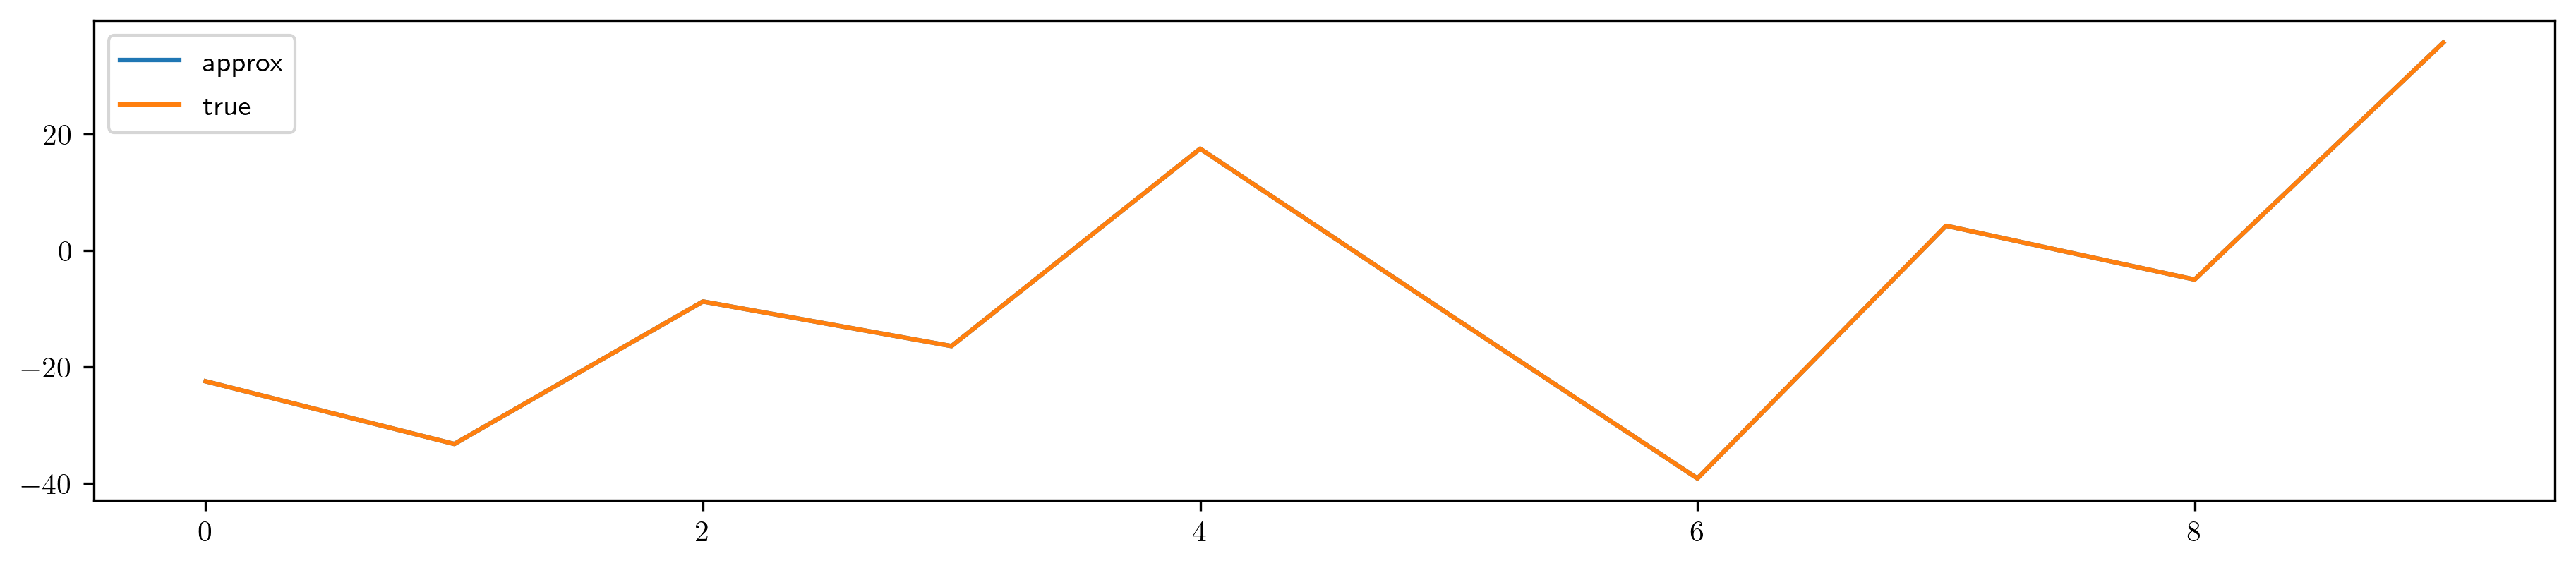

<tf.Variable 'dense_3/bias:0' shape=(10,) dtype=float32, numpy=
array([-0.17471786, -0.00859502, -0.0643498 ,  0.01480074,  0.0324261 ,
        0.0717188 , -0.12568887,  0.08467854,  0.11042465, -0.04813715],
      dtype=float32)>

In [436]:
plt.figure(figsize=(15, 3))
plt.plot(outs, label='approx')
plt.plot(a, label='true')
plt.legend()
plt.show()

model1.layers[-1].weights[1]

#### Combine linear layers

In [437]:
W_conv = model_final.layers[4].weights[0]
W_conv = np.transpose(W_conv, (3, 2, 0, 1))
W_conv_biases = model_final.layers[4].weights[1]

M_1 = conv_weights(d_in=13, W_c=avg_pool_weights(c_in=5, k=3), s=1, padding='same', pool=True)
M_2 = conv_weights(d_in=13, W_c=W_conv, s=2, padding='valid')
M_3 = conv_weights(d_in=5, W_c=avg_pool_weights(c_in=50, k=3), s=1, padding='same', pool=True)
M_4 = dense_weights(model1.layers[7].weights[0].numpy(), 50).transpose()

b_2 = conv_biases(d_in=13, W_c=W_conv, biases=W_conv_biases, s=2, padding='valid')
b_4 = model_final.layers[7].weights[1].numpy()

100%|██████████| 1250/1250 [00:00<00:00, 2883.31it/s]


In [438]:
M = np.matmul(M_2, M_1)
M = np.matmul(M_3, M)
M = np.matmul(M_4, M)

In [439]:
b = np.matmul(M_4, np.matmul(M_3, b_2)) + b_4
b.shape
M.shape


(100, 845)

In [440]:
save_data(model1, name, linear=[(M.transpose(), b, 3, 8, True)])

(7, 2)


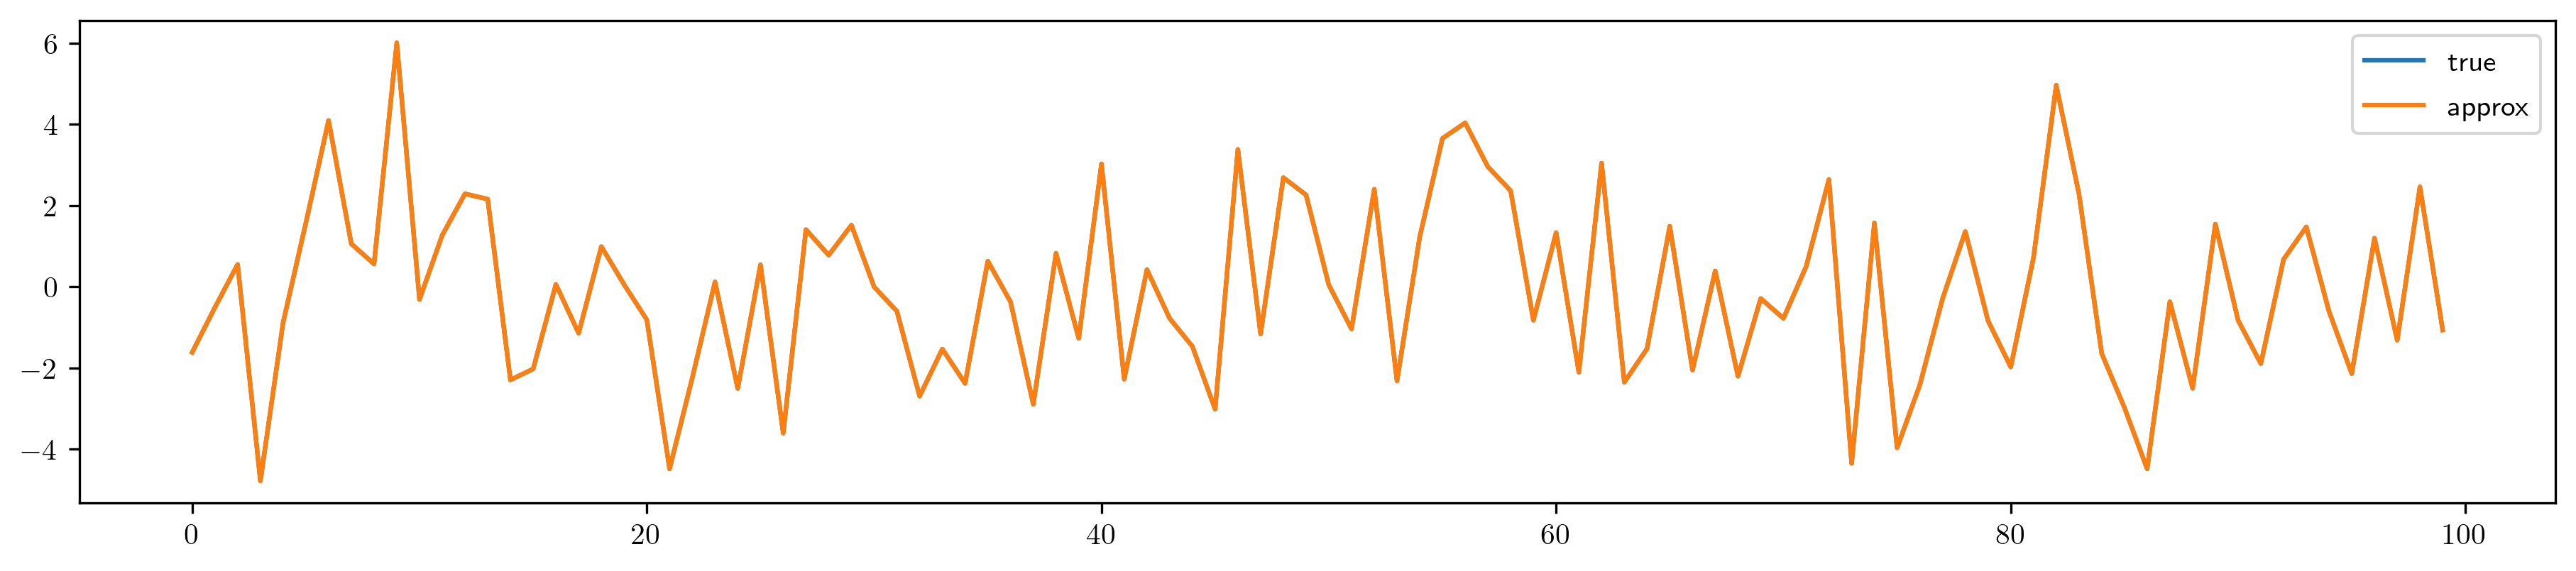

In [340]:
image = np.random.uniform(-1, 1, (1, 13, 13, 5))

ref = model1.layers[7](model1.layers[6](model1.layers[5](model1.layers[4](model1.layers[3](image))))).numpy()[0]
test = np.matmul(M, np.transpose(image, (0, 3, 1, 2)).flatten()) +b


plt.figure(figsize=(15, 3))
plt.plot(ref, label='true')
plt.plot(test, label='approx')
plt.legend()
plt.show()

#### Lottery pruning

In [476]:
from keras.layers import Permute

def mnist_cryptonets_lottery(activation=square_activation):
    model = Sequential()
    model.add(ZeroPadding2D(padding=(1, 1), input_shape=(28, 28, 1)))
    model.add(Conv2D(5, (5, 5), strides=2, padding='valid'))
    model.add(Activation(activation))
    model.add(Permute((3, 1, 2)))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Activation(activation))
    model.add(Dense(10, activation='sigmoid'))

    opt = Adam(lr=0.0005)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [541]:
model_lottery = mnist_cryptonets_lottery()
weights_start = model_lottery.get_weights()

model_lottery.set_weights([
    model1.get_weights()[0],
    model1.get_weights()[1],
    M.transpose(),
    b,
    model1.get_weights()[6],
    model1.get_weights()[7],
])

model_lottery.evaluate(trainX, trainY)

1875/1875 [==============================] - 1s 707us/step - loss: 0.0132 - accuracy: 0.9957


[0.014505201019346714, 0.9952666759490967]

In [505]:
model_lottery.save('saved_model/mnist_lottery_trained')

INFO:tensorflow:Assets written to: saved_model/mnist_lottery_trained/assets


In [542]:
model_lottery = tf.keras.models.load_model('saved_model/mnist_lottery_trained')
#weights_start = model_lottery.get_weights()
model_lottery.evaluate(testX, testY)

313/313 [==============================] - 0s 901us/step - loss: 0.0340 - accuracy: 0.9910


[0.0339924655854702, 0.9909999966621399]

In [543]:
import lottery_ticket_pruner

pruner = lottery_ticket_pruner.LotteryTicketPruner(model_lottery)

def fit_pruned(model, pruner, trainX, trainY, testX, testY, batch_size, epochs):
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1)]
    if pruner is not None:
        callbacks += [lottery_ticket_pruner.PrunerCallback(pruner, use_dwr=False)]
    model.fit(trainX, trainY,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(testX, testY),
              callbacks=callbacks
    )
    
pruner.set_pretrained_weights(model_lottery)
rates = [0.9]
rate_total = 0.0
n = 1

In [544]:
for i in range(n):
    rate = rates[i]
    rate = pow(rate, 1.0 / (i + 1))
    rate_total += (1.0 - rate_total) * rate

    pruner.calc_prune_mask(model_lottery, rate, 'smallest_weights_global')
    
    prune_trained_model = mnist_cryptonets_lottery(square_activation)
    prune_trained_model.set_weights(weights_start)   
    fit_pruned(prune_trained_model, pruner, trainX, trainY, testX, testY, batch_size=128, epochs=250)

Epoch 1/250
469/469 [==============================] - 1s 2ms/step - loss: 1.1584 - accuracy: 0.6421 - val_loss: 0.2101 - val_accuracy: 0.9516
Epoch 2/250
469/469 [==============================] - 1s 2ms/step - loss: 1.2236 - accuracy: 0.6011 - val_loss: 0.2552 - val_accuracy: 0.9368
Epoch 3/250
469/469 [==============================] - 1s 2ms/step - loss: 0.6341 - accuracy: 0.8608 - val_loss: 0.1966 - val_accuracy: 0.9461
Epoch 4/250
469/469 [==============================] - 1s 2ms/step - loss: 0.4291 - accuracy: 0.9017 - val_loss: 0.1756 - val_accuracy: 0.9550
Epoch 5/250
469/469 [==============================] - 1s 2ms/step - loss: 0.3284 - accuracy: 0.9214 - val_loss: 0.1623 - val_accuracy: 0.9566
Epoch 6/250
469/469 [==============================] - 1s 2ms/step - loss: 0.2698 - accuracy: 0.9321 - val_loss: 0.1472 - val_accuracy: 0.9602
Epoch 7/250
469/469 [==============================] - 1s 2ms/step - loss: 0.2342 - accuracy: 0.9402 - val_loss: 0.1364 - val_accuracy: 0.9636

In [546]:
masks = []
for layer_idx, weight_idx in pruner.prunable_tuples:
    mask = pruner.prune_masks_map[(layer_idx, weight_idx)]
    weight_mask = np.array(mask[0])
    masks.append(weight_mask)
    print(np.sum(weight_mask))
    
prune_trained_model.evaluate(testX, testY)
prune_trained_model.layers[1].weights[0]

19
8316
228
313/313 [==============================] - 0s 956us/step - loss: 0.1498 - accuracy: 0.9650


<tf.Variable 'conv2d_121/kernel:0' shape=(5, 5, 1, 5) dtype=float32, numpy=
array([[[[ 0.05688564, -0.        , -0.        , -0.        ,
          -0.        ]],

        [[ 0.        , -0.        ,  0.        , -0.        ,
           0.        ]],

        [[ 0.        ,  0.18784058,  0.        , -0.        ,
           0.        ]],

        [[ 0.        ,  0.        ,  0.        , -0.        ,
           0.        ]],

        [[ 0.        , -0.        , -0.        ,  0.        ,
           0.        ]]],


       [[[ 0.        , -0.        , -0.        , -0.        ,
           0.        ]],

        [[ 0.        , -0.3312345 ,  0.        , -0.        ,
           0.        ]],

        [[ 0.06614976, -0.        ,  0.        , -0.        ,
           0.        ]],

        [[ 0.        ,  0.70473754, -0.        , -0.        ,
           0.        ]],

        [[ 0.        , -0.        , -0.        ,  1.0379444 ,
           0.        ]]],


       [[[-0.5789101 , -0.        , -0. 

In [510]:
save_data(prune_trained_model, 'LOTTERY', linear=[])

(7, 2)


### FAST MNIST model

#### Train model

In [11]:
name = 'MNIST-OPT'

trainX, trainY, testX, testY = load_dataset_mnist()
trainX, testX = prep_pixels(trainX, testX)

model2 = mnist_opt()

callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

model2.fit(
    trainX, trainY,
    epochs=1,
    validation_data=(testX, testY),
    workers=6,
    callbacks=[callback]
)
model2.save('saved_model/' + name)

1875/1875 [==============================] - 3s 2ms/step - loss: 1.1072 - accuracy: 0.6657 - val_loss: 0.2158 - val_accuracy: 0.9415
INFO:tensorflow:Assets written to: saved_model/MNIST-OPT/assets


In [ ]:
model2 = tf.keras.models.load_model('saved_model/' + name)

In [12]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_4 (ZeroPaddin (None, 30, 30, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 5)         50        
_________________________________________________________________
activation_8 (Activation)    (None, 28, 28, 5)         0         
_________________________________________________________________
average_pooling2d_8 (Average (None, 14, 14, 5)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 50)        2300      
_________________________________________________________________
average_pooling2d_9 (Average (None, 12, 12, 50)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 7200)             

#### Combine linear layers

In [105]:
W_conv = model2.layers[4].weights[0]
W_conv = np.transpose(W_conv, (3, 2, 0, 1))
W_conv_biases = model2.layers[4].weights[1]

M_1 = conv_weights(d_in=28, W_c=avg_pool_weights(c_in=5, k=3), s=2, padding='same', pool=True)
M_2 = conv_weights(d_in=14, W_c=W_conv, s=1, padding='valid')
M_3 = conv_weights(d_in=12, W_c=avg_pool_weights(c_in=50, k=3), s=1, padding='same', pool=True)
M_4 = dense_weights(model2.layers[7].weights[0].numpy(), 50).transpose()

b_2 = conv_biases(d_in=14, W_c=W_conv, biases=W_conv_biases, s=1, padding='valid')
b_4 = model2.layers[7].weights[1].numpy()

100%|██████████| 7200/7200 [00:02<00:00, 2445.22it/s]


In [106]:
M = M_4 @ M_3 @ M_2 @ M_1

In [107]:
M.shape

(32, 3920)

In [108]:
b = M_4 @ M_3 @ b_2 + b_4

image = np.random.uniform(-1, 1, (1, 28, 28, 5))

ref = model2.layers[7](model2.layers[6](model2.layers[5](model2.layers[4](model2.layers[3](image))))).numpy()[0]
test = np.matmul(M, np.transpose(image, (0, 3, 1, 2)).flatten()) + b


plt.figure(figsize=(15, 3))
plt.plot(ref, label='true')
plt.plot(test + .5, label='approx')
plt.legend()
plt.show()

In [110]:
save_data(model2, name, linear=[(M.transpose(), b, 3, 8, True)])

(7, 2)


#### Exploding gradients

In [10]:
def square_activation(x):
    return K.square(x)

def special_activation(x):
    return 0.125 * K.square(x) + 0.5 * x + 0.125

In [11]:
for i in range(4):
    mnist_opt_bn().save_weights('saved_weights/MNIST-OPT-INIT' + str(i))

In [12]:
activations = [square_activation, special_activation, 'relu']
hs = []

for i in range(4):
    d = []
        
    for a in activations:
        cn = mnist_opt_bn(a)
        cn.load_weights('saved_weights/MNIST-OPT-INIT' + str(i))
        cn.layers[3] = a
        cn.layers[10] = a
    
        callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000)
        history = cn.fit(
            trainX, trainY,
            epochs=80,
            validation_data=(testX, testY),
            batch_size=128,
            workers=6
        )
        d.append(history.history)
    hs.append(d)

Epoch 1/80
469/469 [==============================] - 5s 3ms/step - loss: 1.6481 - accuracy: 0.5081 - val_loss: 3.0294 - val_accuracy: 0.2191
Epoch 2/80
469/469 [==============================] - 1s 3ms/step - loss: 0.4184 - accuracy: 0.9128 - val_loss: 0.2951 - val_accuracy: 0.9406
Epoch 3/80
469/469 [==============================] - 1s 3ms/step - loss: 0.2932 - accuracy: 0.9432 - val_loss: 0.2312 - val_accuracy: 0.9549
Epoch 4/80
469/469 [==============================] - 1s 3ms/step - loss: 0.2278 - accuracy: 0.9576 - val_loss: 0.1766 - val_accuracy: 0.9661
Epoch 5/80
469/469 [==============================] - 1s 3ms/step - loss: 0.1911 - accuracy: 0.9634 - val_loss: 0.1528 - val_accuracy: 0.9692
Epoch 6/80
469/469 [==============================] - 1s 3ms/step - loss: 0.1612 - accuracy: 0.9694 - val_loss: 0.1332 - val_accuracy: 0.9740
Epoch 7/80
469/469 [==============================] - 1s 3ms/step - loss: 0.1431 - accuracy: 0.9734 - val_loss: 0.1212 - val_accuracy: 0.9730
Epoch 

469/469 [==============================] - 1s 3ms/step - loss: 0.0498 - accuracy: 0.9875 - val_loss: 0.0533 - val_accuracy: 0.9851
Epoch 36/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0481 - accuracy: 0.9881 - val_loss: 0.0548 - val_accuracy: 0.9850
Epoch 37/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0467 - accuracy: 0.9884 - val_loss: 0.0530 - val_accuracy: 0.9848
Epoch 38/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0433 - accuracy: 0.9893 - val_loss: 0.0518 - val_accuracy: 0.9838
Epoch 39/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0442 - accuracy: 0.9892 - val_loss: 0.0527 - val_accuracy: 0.9843
Epoch 40/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0417 - accuracy: 0.9901 - val_loss: 0.0521 - val_accuracy: 0.9854
Epoch 41/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0422 - accuracy: 0.9896 - val_loss: 0.0474 - val_accuracy: 0.9864
Epoch 42/80

469/469 [==============================] - 1s 3ms/step - loss: 0.0227 - accuracy: 0.9947 - val_loss: 0.0527 - val_accuracy: 0.9836
Epoch 70/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0230 - accuracy: 0.9945 - val_loss: 0.0463 - val_accuracy: 0.9855
Epoch 71/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0222 - accuracy: 0.9948 - val_loss: 0.0486 - val_accuracy: 0.9851
Epoch 72/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0232 - accuracy: 0.9945 - val_loss: 0.0487 - val_accuracy: 0.9844
Epoch 73/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0227 - accuracy: 0.9949 - val_loss: 0.0495 - val_accuracy: 0.9840
Epoch 74/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0222 - accuracy: 0.9953 - val_loss: 0.0494 - val_accuracy: 0.9845
Epoch 75/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0225 - accuracy: 0.9947 - val_loss: 0.0429 - val_accuracy: 0.9863
Epoch 76/80

469/469 [==============================] - 1s 3ms/step - loss: 0.0704 - accuracy: 0.9835 - val_loss: 0.0643 - val_accuracy: 0.9839
Epoch 24/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0664 - accuracy: 0.9847 - val_loss: 0.0648 - val_accuracy: 0.9826
Epoch 25/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0631 - accuracy: 0.9846 - val_loss: 0.0609 - val_accuracy: 0.9843
Epoch 26/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0631 - accuracy: 0.9852 - val_loss: 0.0619 - val_accuracy: 0.9824
Epoch 27/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0580 - accuracy: 0.9861 - val_loss: 0.0587 - val_accuracy: 0.9834
Epoch 28/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0565 - accuracy: 0.9864 - val_loss: 0.0592 - val_accuracy: 0.9842
Epoch 29/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0579 - accuracy: 0.9858 - val_loss: 0.0550 - val_accuracy: 0.9834
Epoch 30/80

469/469 [==============================] - 1s 3ms/step - loss: 0.0315 - accuracy: 0.9923 - val_loss: 0.0474 - val_accuracy: 0.9859
Epoch 58/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0296 - accuracy: 0.9932 - val_loss: 0.0422 - val_accuracy: 0.9874
Epoch 59/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0284 - accuracy: 0.9931 - val_loss: 0.0429 - val_accuracy: 0.9875
Epoch 60/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0270 - accuracy: 0.9938 - val_loss: 0.0436 - val_accuracy: 0.9868
Epoch 61/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0289 - accuracy: 0.9930 - val_loss: 0.0422 - val_accuracy: 0.9865
Epoch 62/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0269 - accuracy: 0.9933 - val_loss: 0.0447 - val_accuracy: 0.9857
Epoch 63/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0271 - accuracy: 0.9935 - val_loss: 0.0430 - val_accuracy: 0.9871
Epoch 64/80

469/469 [==============================] - 1s 3ms/step - loss: 0.1508 - accuracy: 0.9756 - val_loss: 0.1303 - val_accuracy: 0.9769
Epoch 12/80
469/469 [==============================] - 1s 3ms/step - loss: 0.1417 - accuracy: 0.9747 - val_loss: 0.1204 - val_accuracy: 0.9785
Epoch 13/80
469/469 [==============================] - 1s 3ms/step - loss: 0.1260 - accuracy: 0.9778 - val_loss: 0.1264 - val_accuracy: 0.9747
Epoch 14/80
469/469 [==============================] - 1s 3ms/step - loss: 0.1202 - accuracy: 0.9771 - val_loss: 0.1048 - val_accuracy: 0.9801
Epoch 15/80
469/469 [==============================] - 1s 3ms/step - loss: 0.1111 - accuracy: 0.9783 - val_loss: 0.0986 - val_accuracy: 0.9794
Epoch 16/80
469/469 [==============================] - 1s 3ms/step - loss: 0.1044 - accuracy: 0.9790 - val_loss: 0.0926 - val_accuracy: 0.9799
Epoch 17/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0989 - accuracy: 0.9791 - val_loss: 0.0927 - val_accuracy: 0.9814
Epoch 18/80

469/469 [==============================] - 1s 3ms/step - loss: 0.0372 - accuracy: 0.9905 - val_loss: 0.0518 - val_accuracy: 0.9839
Epoch 46/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0361 - accuracy: 0.9906 - val_loss: 0.0507 - val_accuracy: 0.9837
Epoch 47/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0335 - accuracy: 0.9919 - val_loss: 0.0762 - val_accuracy: 0.9754
Epoch 48/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0331 - accuracy: 0.9919 - val_loss: 0.0641 - val_accuracy: 0.9801
Epoch 49/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0342 - accuracy: 0.9914 - val_loss: 0.0528 - val_accuracy: 0.9846
Epoch 50/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0331 - accuracy: 0.9916 - val_loss: 0.0516 - val_accuracy: 0.9840
Epoch 51/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0323 - accuracy: 0.9918 - val_loss: 0.0596 - val_accuracy: 0.9822
Epoch 52/80

469/469 [==============================] - 1s 3ms/step - loss: 0.0100 - accuracy: 0.9980 - val_loss: 0.0579 - val_accuracy: 0.9861
Epoch 80/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0108 - accuracy: 0.9976 - val_loss: 0.0614 - val_accuracy: 0.9855
Epoch 1/80
469/469 [==============================] - 2s 3ms/step - loss: 1.1039 - accuracy: 0.7430 - val_loss: 1.0514 - val_accuracy: 0.7936
Epoch 2/80
469/469 [==============================] - 1s 3ms/step - loss: 0.5733 - accuracy: 0.9257 - val_loss: 0.4604 - val_accuracy: 0.9314
Epoch 3/80
469/469 [==============================] - 1s 3ms/step - loss: 0.4511 - accuracy: 0.9489 - val_loss: 0.3619 - val_accuracy: 0.9564
Epoch 4/80
469/469 [==============================] - 1s 3ms/step - loss: 0.3720 - accuracy: 0.9570 - val_loss: 0.3095 - val_accuracy: 0.9642
Epoch 5/80
469/469 [==============================] - 1s 3ms/step - loss: 0.3128 - accuracy: 0.9627 - val_loss: 0.2604 - val_accuracy: 0.9666
Epoch 6/80
469/4

469/469 [==============================] - 1s 3ms/step - loss: 0.0482 - accuracy: 0.9872 - val_loss: 0.0554 - val_accuracy: 0.9834
Epoch 34/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0491 - accuracy: 0.9876 - val_loss: 0.0560 - val_accuracy: 0.9836
Epoch 35/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0459 - accuracy: 0.9884 - val_loss: 0.0560 - val_accuracy: 0.9844
Epoch 36/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0431 - accuracy: 0.9892 - val_loss: 0.0584 - val_accuracy: 0.9834
Epoch 37/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0427 - accuracy: 0.9897 - val_loss: 0.0564 - val_accuracy: 0.9836
Epoch 38/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0419 - accuracy: 0.9896 - val_loss: 0.0647 - val_accuracy: 0.9805
Epoch 39/80
469/469 [==============================] - 1s 3ms/step - loss: 0.0423 - accuracy: 0.9887 - val_loss: 0.0649 - val_accuracy: 0.9796
Epoch 40/80

In [13]:
for i in range(4):
    mnist_opt().save_weights('saved_weights/MNIST-OPT-INIT' + str(i))
    
for i in range(4):
    d = []
        
    for a in activations:
        cn = mnist_opt(a)
        cn.load_weights('saved_weights/MNIST-OPT-INIT' + str(i))

        cn.layers[2] = a
        cn.layers[8] = a
    
        callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000)
        history = cn.fit(
            trainX, trainY,
            epochs=80,
            validation_data=(testX, testY),
            batch_size=128,
            workers=6
        )
        d.append(history.history)
    hs.append(d)

Epoch 1/80
469/469 [==============================] - 1s 3ms/step - loss: 1.6865 - accuracy: 0.4887 - val_loss: 0.5073 - val_accuracy: 0.8675
Epoch 2/80
469/469 [==============================] - 1s 2ms/step - loss: 0.5020 - accuracy: 0.8668 - val_loss: 0.4122 - val_accuracy: 0.8877
Epoch 3/80
469/469 [==============================] - 1s 2ms/step - loss: 0.4180 - accuracy: 0.8856 - val_loss: 0.3557 - val_accuracy: 0.9045
Epoch 4/80
469/469 [==============================] - 1s 2ms/step - loss: 0.3608 - accuracy: 0.9014 - val_loss: 0.3144 - val_accuracy: 0.9152
Epoch 5/80
469/469 [==============================] - 1s 2ms/step - loss: 0.3115 - accuracy: 0.9152 - val_loss: 0.2679 - val_accuracy: 0.9259
Epoch 6/80
469/469 [==============================] - 1s 2ms/step - loss: 0.2713 - accuracy: 0.9260 - val_loss: 0.2353 - val_accuracy: 0.9385
Epoch 7/80
469/469 [==============================] - 1s 2ms/step - loss: 0.2356 - accuracy: 0.9346 - val_loss: 0.2109 - val_accuracy: 0.9451
Epoch 

469/469 [==============================] - 1s 2ms/step - loss: 0.1839 - accuracy: 0.9458 - val_loss: 0.1809 - val_accuracy: 0.9458
Epoch 36/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1843 - accuracy: 0.9451 - val_loss: 0.1783 - val_accuracy: 0.9471
Epoch 37/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1795 - accuracy: 0.9469 - val_loss: 0.1712 - val_accuracy: 0.9491
Epoch 38/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1753 - accuracy: 0.9474 - val_loss: 0.1687 - val_accuracy: 0.9497
Epoch 39/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1674 - accuracy: 0.9492 - val_loss: 0.1667 - val_accuracy: 0.9482
Epoch 40/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1685 - accuracy: 0.9493 - val_loss: 0.1639 - val_accuracy: 0.9514
Epoch 41/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1629 - accuracy: 0.9525 - val_loss: 0.1628 - val_accuracy: 0.9527
Epoch 42/80

469/469 [==============================] - 1s 2ms/step - loss: 0.1009 - accuracy: 0.9699 - val_loss: 0.0991 - val_accuracy: 0.9695
Epoch 70/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0994 - accuracy: 0.9710 - val_loss: 0.1004 - val_accuracy: 0.9699
Epoch 71/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0967 - accuracy: 0.9717 - val_loss: 0.0979 - val_accuracy: 0.9703
Epoch 72/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0948 - accuracy: 0.9712 - val_loss: 0.1031 - val_accuracy: 0.9684
Epoch 73/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0986 - accuracy: 0.9705 - val_loss: 0.0965 - val_accuracy: 0.9714
Epoch 74/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0928 - accuracy: 0.9719 - val_loss: 0.0957 - val_accuracy: 0.9719
Epoch 75/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0964 - accuracy: 0.9707 - val_loss: 0.0953 - val_accuracy: 0.9713
Epoch 76/80

469/469 [==============================] - 1s 2ms/step - loss: 0.2011 - accuracy: 0.9390 - val_loss: 0.1903 - val_accuracy: 0.9444
Epoch 24/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1955 - accuracy: 0.9409 - val_loss: 0.1868 - val_accuracy: 0.9439
Epoch 25/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1904 - accuracy: 0.9429 - val_loss: 0.1853 - val_accuracy: 0.9442
Epoch 26/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1845 - accuracy: 0.9457 - val_loss: 0.1770 - val_accuracy: 0.9468
Epoch 27/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1778 - accuracy: 0.9460 - val_loss: 0.1773 - val_accuracy: 0.9484
Epoch 28/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1726 - accuracy: 0.9475 - val_loss: 0.1684 - val_accuracy: 0.9500
Epoch 29/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1746 - accuracy: 0.9472 - val_loss: 0.1669 - val_accuracy: 0.9520
Epoch 30/80

469/469 [==============================] - 1s 2ms/step - loss: 0.0862 - accuracy: 0.9737 - val_loss: 0.0835 - val_accuracy: 0.9733
Epoch 58/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0868 - accuracy: 0.9741 - val_loss: 0.0826 - val_accuracy: 0.9741
Epoch 59/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0841 - accuracy: 0.9748 - val_loss: 0.0850 - val_accuracy: 0.9737
Epoch 60/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0826 - accuracy: 0.9757 - val_loss: 0.0817 - val_accuracy: 0.9739
Epoch 61/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0866 - accuracy: 0.9736 - val_loss: 0.0803 - val_accuracy: 0.9744
Epoch 62/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0837 - accuracy: 0.9751 - val_loss: 0.0810 - val_accuracy: 0.9746
Epoch 63/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0806 - accuracy: 0.9761 - val_loss: 0.0797 - val_accuracy: 0.9753
Epoch 64/80

469/469 [==============================] - 1s 2ms/step - loss: 0.2832 - accuracy: 0.9135 - val_loss: 0.2634 - val_accuracy: 0.9219
Epoch 12/80
469/469 [==============================] - 1s 2ms/step - loss: 0.2763 - accuracy: 0.9154 - val_loss: 0.2506 - val_accuracy: 0.9248
Epoch 13/80
469/469 [==============================] - 1s 2ms/step - loss: 0.2587 - accuracy: 0.9211 - val_loss: 0.2427 - val_accuracy: 0.9271
Epoch 14/80
469/469 [==============================] - 1s 2ms/step - loss: 0.2604 - accuracy: 0.9212 - val_loss: 0.2304 - val_accuracy: 0.9324
Epoch 15/80
469/469 [==============================] - 1s 2ms/step - loss: 0.2481 - accuracy: 0.9258 - val_loss: 0.2231 - val_accuracy: 0.9326
Epoch 16/80
469/469 [==============================] - 1s 2ms/step - loss: 0.2402 - accuracy: 0.9281 - val_loss: 0.2198 - val_accuracy: 0.9339
Epoch 17/80
469/469 [==============================] - 1s 2ms/step - loss: 0.2288 - accuracy: 0.9317 - val_loss: 0.2140 - val_accuracy: 0.9373
Epoch 18/80

469/469 [==============================] - 1s 2ms/step - loss: 0.0949 - accuracy: 0.9708 - val_loss: 0.0872 - val_accuracy: 0.9727
Epoch 46/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0918 - accuracy: 0.9731 - val_loss: 0.0841 - val_accuracy: 0.9736
Epoch 47/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0903 - accuracy: 0.9733 - val_loss: 0.0844 - val_accuracy: 0.9731
Epoch 48/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0924 - accuracy: 0.9725 - val_loss: 0.0821 - val_accuracy: 0.9743
Epoch 49/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0941 - accuracy: 0.9717 - val_loss: 0.0817 - val_accuracy: 0.9744
Epoch 50/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0886 - accuracy: 0.9733 - val_loss: 0.0818 - val_accuracy: 0.9748
Epoch 51/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0877 - accuracy: 0.9729 - val_loss: 0.0796 - val_accuracy: 0.9743
Epoch 52/80

469/469 [==============================] - 1s 2ms/step - loss: 0.0475 - accuracy: 0.9856 - val_loss: 0.0465 - val_accuracy: 0.9848
Epoch 80/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0474 - accuracy: 0.9856 - val_loss: 0.0493 - val_accuracy: 0.9831
Epoch 1/80
469/469 [==============================] - 1s 3ms/step - loss: 1.9942 - accuracy: 0.4624 - val_loss: 0.6613 - val_accuracy: 0.8170
Epoch 2/80
469/469 [==============================] - 1s 2ms/step - loss: 0.6040 - accuracy: 0.8296 - val_loss: 0.4674 - val_accuracy: 0.8677
Epoch 3/80
469/469 [==============================] - 1s 2ms/step - loss: 0.4783 - accuracy: 0.8592 - val_loss: 0.4337 - val_accuracy: 0.8773
Epoch 4/80
469/469 [==============================] - 1s 2ms/step - loss: 0.4348 - accuracy: 0.8742 - val_loss: 0.3938 - val_accuracy: 0.8866
Epoch 5/80
469/469 [==============================] - 1s 2ms/step - loss: 0.4113 - accuracy: 0.8819 - val_loss: 0.3855 - val_accuracy: 0.8887
Epoch 6/80
469/4

469/469 [==============================] - 1s 2ms/step - loss: 0.1069 - accuracy: 0.9696 - val_loss: 0.0960 - val_accuracy: 0.9684
Epoch 34/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1065 - accuracy: 0.9694 - val_loss: 0.0943 - val_accuracy: 0.9701
Epoch 35/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1025 - accuracy: 0.9703 - val_loss: 0.0902 - val_accuracy: 0.9707
Epoch 36/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1031 - accuracy: 0.9692 - val_loss: 0.0922 - val_accuracy: 0.9701
Epoch 37/80
469/469 [==============================] - 1s 2ms/step - loss: 0.1038 - accuracy: 0.9701 - val_loss: 0.0872 - val_accuracy: 0.9732
Epoch 38/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0999 - accuracy: 0.9717 - val_loss: 0.0885 - val_accuracy: 0.9706
Epoch 39/80
469/469 [==============================] - 1s 2ms/step - loss: 0.0999 - accuracy: 0.9713 - val_loss: 0.0850 - val_accuracy: 0.9721
Epoch 40/80

In [9]:
hs = np.load('histories.npy', allow_pickle=True)

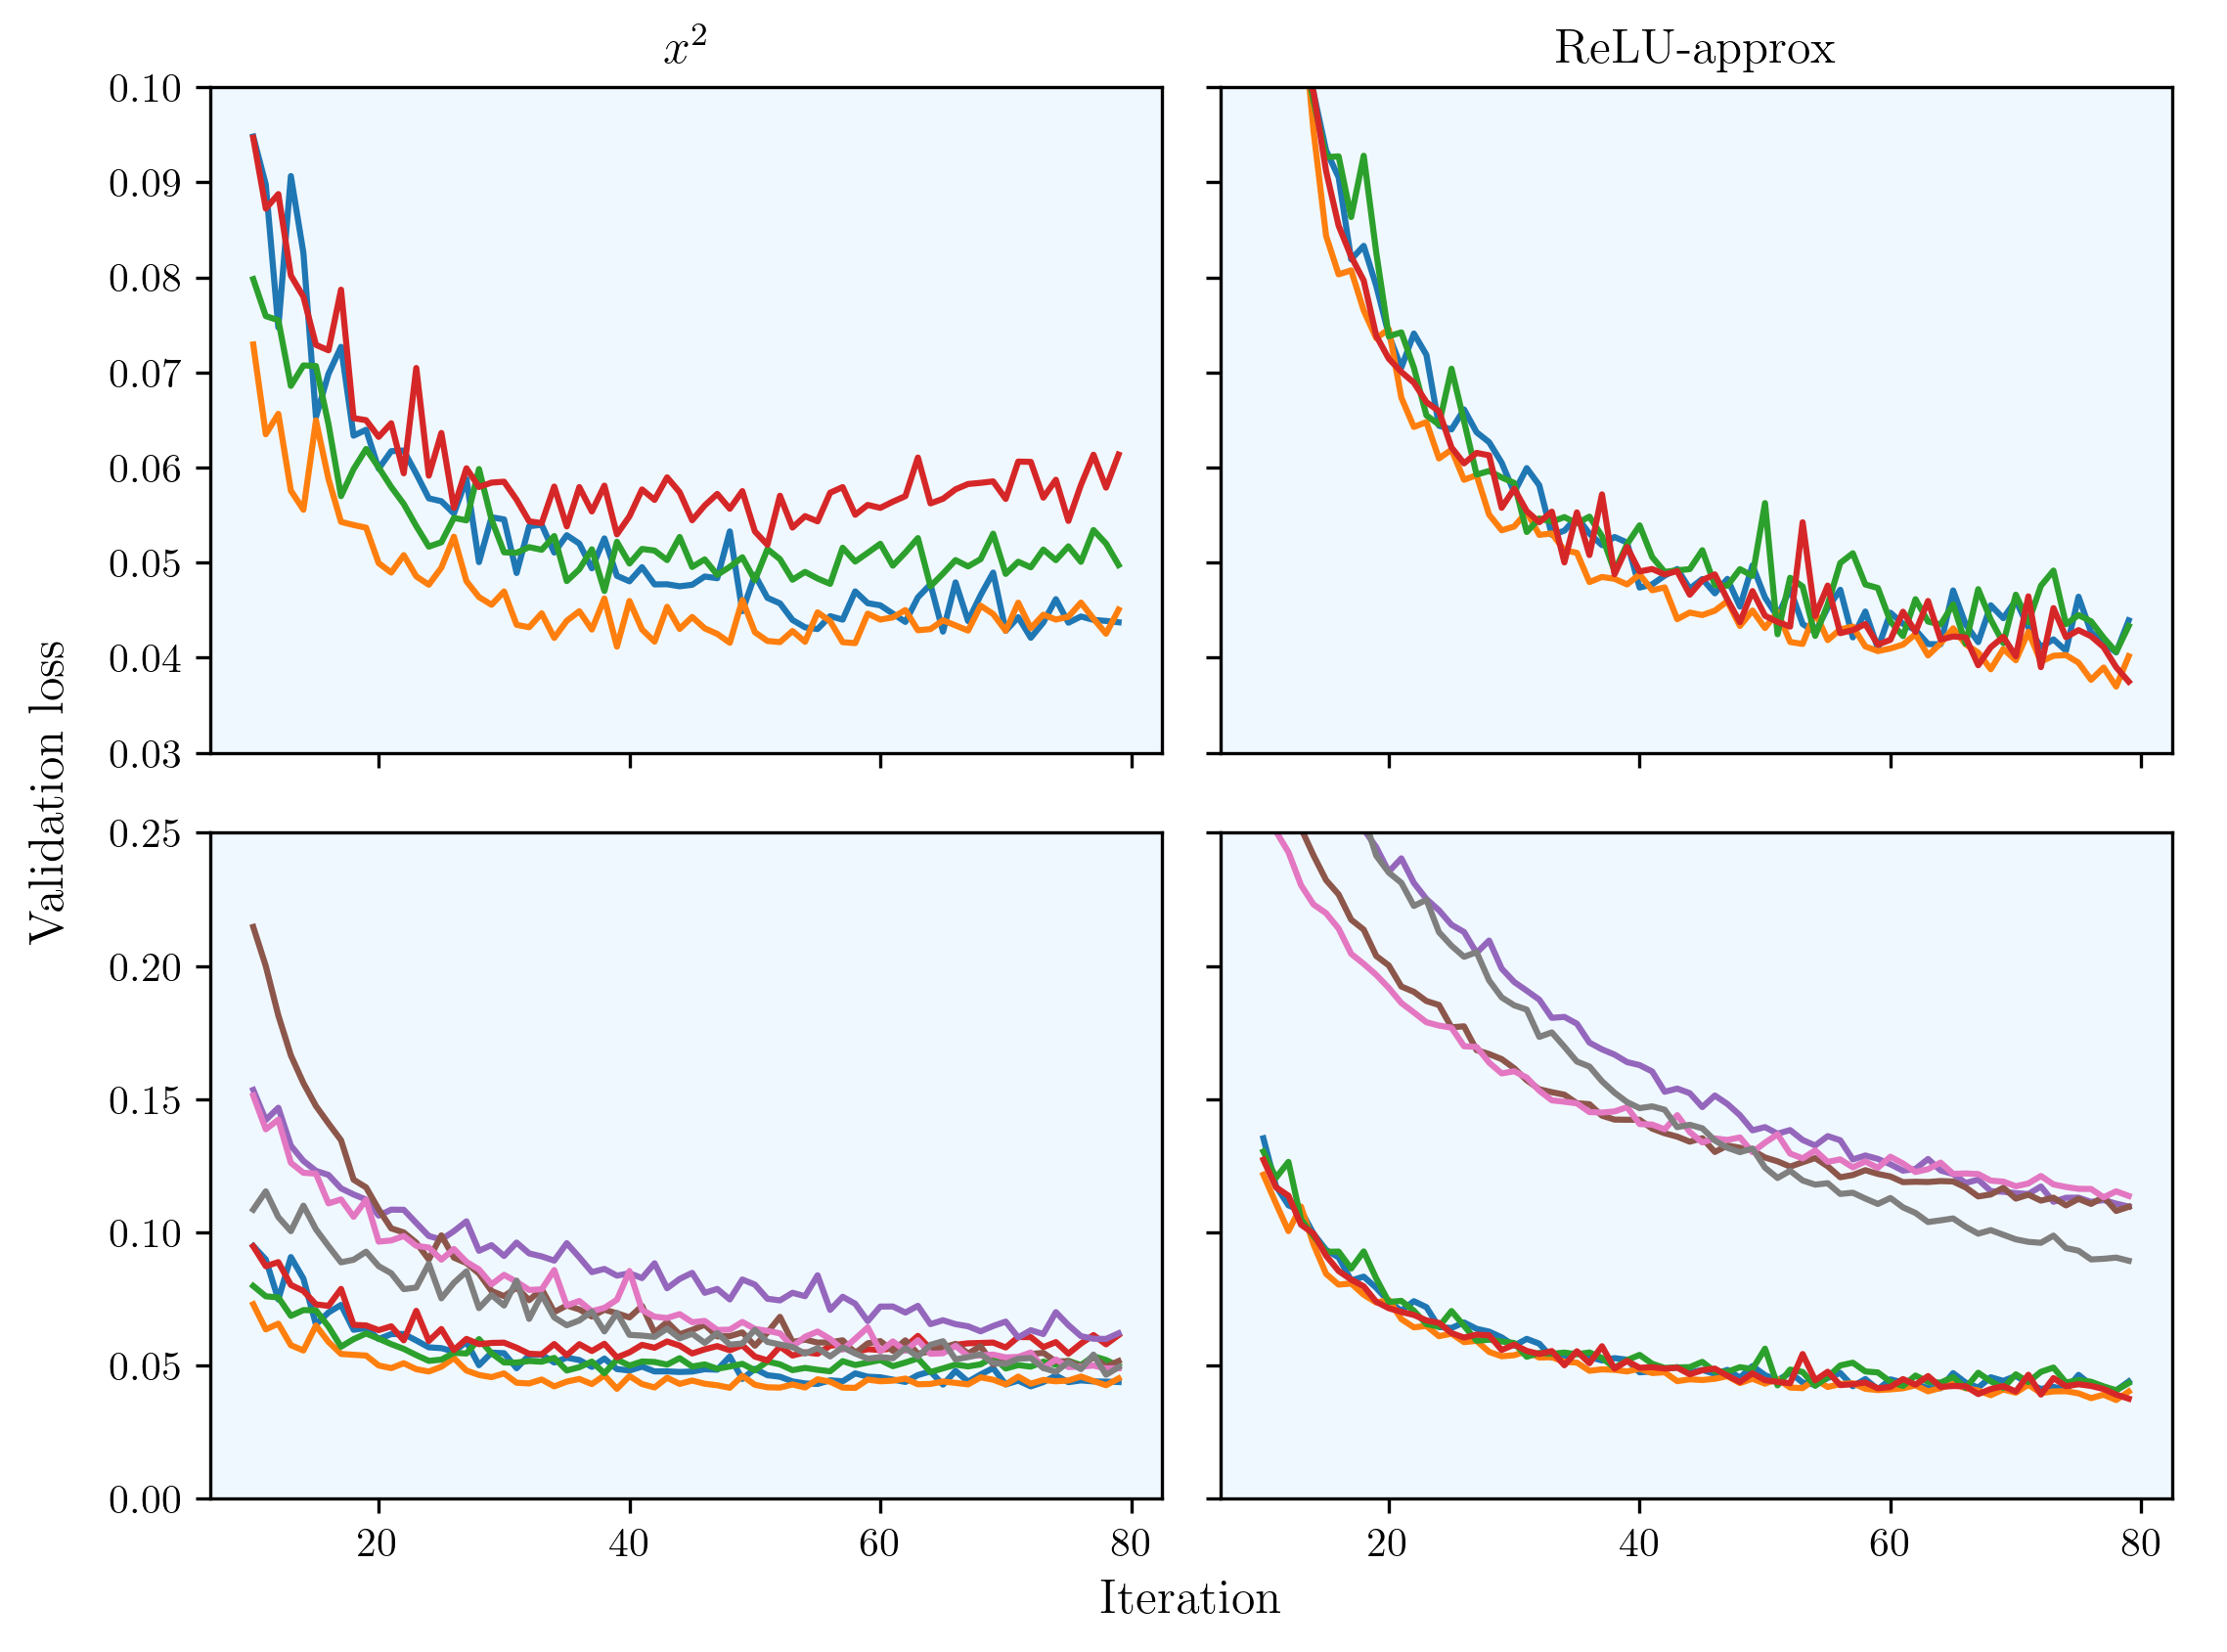

In [70]:
import numpy as np
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 's'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['figure.dpi'] = 300

fig, axs = plt.subplots(2,2, figsize=(8,6), sharex=True, sharey='row')


for i in range(0,4):
    axs[0, 0].plot(np.arange(10, 80), hs[i][0]['val_loss'][10:])
axs[0, 0].set_ylim([0.03,0.1])

for i in range(0,4):
    axs[0, 1].plot(np.arange(10, 80), hs[i][1]['val_loss'][10:])
axs[0, 1].set_ylim([0.03,0.1])


for i in range(0,4):
    axs[1, 0].plot(np.arange(10, 80), hs[i][0]['val_loss'][10:])
for i in range(0,4):
    axs[1, 1].plot(np.arange(10, 80), hs[i][1]['val_loss'][10:])
    
for i in range(4,8):
    axs[1, 0].plot(np.arange(10, 80), hs[i][0]['val_loss'][10:])
for i in range(4,8):
    axs[1, 1].plot(np.arange(10, 80), hs[i][1]['val_loss'][10:])
axs[1, 1].set_ylim([0.0,0.25])
axs[1, 0].set_ylim([0.0,0.25])

axs[0, 0].title.set_text('$x^2$')
axs[0, 1].title.set_text('ReLU-approx')


fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Validation loss', fontsize=12)
ax = plt.gca()
ax.yaxis.set_label_coords(-0.07, 0.5)
plt.tight_layout()

axs[0, 0].set_facecolor('aliceblue')
axs[0, 1].set_facecolor('aliceblue')
axs[1, 0].set_facecolor('aliceblue')
axs[1, 1].set_facecolor('aliceblue')

fig.savefig('plots/act.pdf', format='pdf', bbox_inches = "tight")

### CIFAR

In [295]:
name = 'CIFAR-1'

trainX, trainY, testX, testY = load_dataset_cifar10()
trainX, testX = prep_pixels(trainX, testX)

In [672]:
model3 = cifar()

callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=35)

model3.fit(
    trainX, trainY,
    epochs=300,
    validation_data=(testX, testY),
    workers=6,
    batch_size=64
)

#model3 = tf.keras.models.load_model('saved_model/' + name)
model3.summary()

Epoch 1/300
782/782 [==============================] - 4s 4ms/step - loss: 2.3007 - accuracy: 0.1142 - val_loss: 2.2021 - val_accuracy: 0.1559
Epoch 2/300
782/782 [==============================] - 3s 4ms/step - loss: 1.8901 - accuracy: 0.3055 - val_loss: 1.5209 - val_accuracy: 0.4402
Epoch 3/300
782/782 [==============================] - 3s 4ms/step - loss: 1.4666 - accuracy: 0.4715 - val_loss: 1.2643 - val_accuracy: 0.5500
Epoch 4/300
782/782 [==============================] - 3s 4ms/step - loss: 3.6583 - accuracy: 0.5570 - val_loss: 1.5471 - val_accuracy: 0.4792
Epoch 5/300
782/782 [==============================] - 3s 4ms/step - loss: 1.4789 - accuracy: 0.4861 - val_loss: 1.2612 - val_accuracy: 0.5548
Epoch 6/300
782/782 [==============================] - 3s 4ms/step - loss: 1.2610 - accuracy: 0.5497 - val_loss: 1.1628 - val_accuracy: 0.5947
Epoch 7/300
782/782 [==============================] - 3s 4ms/step - loss: 1.1607 - accuracy: 0.5858 - val_loss: 1.1126 - val_accuracy: 0.6074

Epoch 58/300
782/782 [==============================] - 3s 4ms/step - loss: 0.3022 - accuracy: 0.8973 - val_loss: 1.4183 - val_accuracy: 0.7378
Epoch 59/300
782/782 [==============================] - 4s 5ms/step - loss: 0.3199 - accuracy: 0.8933 - val_loss: 1.4455 - val_accuracy: 0.7384
Epoch 60/300
782/782 [==============================] - 3s 4ms/step - loss: 0.3131 - accuracy: 0.8936 - val_loss: 1.4795 - val_accuracy: 0.7363
Epoch 61/300
782/782 [==============================] - 3s 4ms/step - loss: 1668.8467 - accuracy: 0.8891 - val_loss: 126.6469 - val_accuracy: 0.1328
Epoch 62/300
782/782 [==============================] - 4s 5ms/step - loss: 71.9272 - accuracy: 0.1584 - val_loss: 15.7844 - val_accuracy: 0.2569
Epoch 63/300
782/782 [==============================] - 4s 5ms/step - loss: 17.7497 - accuracy: 0.2350 - val_loss: 9.3588 - val_accuracy: 0.3214
Epoch 64/300
782/782 [==============================] - 3s 4ms/step - loss: 11.0869 - accuracy: 0.2931 - val_loss: 6.6676 - val_

KeyboardInterrupt: 

In [232]:
model3.save('saved_model/' + name)

INFO:tensorflow:Assets written to: saved_model/CIFAR/assets


#### Combine linear layers

In [233]:
W_conv = np.transpose(model3.layers[3].weights[0], (3, 2, 0, 1))
W_conv_biases = model3.layers[3].weights[1]

M_1 = conv_weights(d_in=30, W_c=avg_pool_weights(c_in=32, k=3), s=3, padding='same', pool=True)
M_2 = conv_weights(d_in=10, W_c=W_conv, s=1, padding='valid')

b_2 = conv_biases(d_in=10, W_c=W_conv, biases=W_conv_biases, s=1, padding='valid')

100%|██████████| 4096/4096 [00:02<00:00, 1895.57it/s]


In [234]:
M_a = M_2 @ M_1
b_a = b_2

In [235]:
M_a.shape

(4096, 28800)

In [236]:
W_conv = np.transpose(model3.layers[7].weights[0], (3, 2, 0, 1))
W_conv_biases = model3.layers[7].weights[1]

M_3 = conv_weights(d_in=8, W_c=avg_pool_weights(c_in=64, k=2), s=2, padding='same', pool=True)
M_4 = conv_weights(d_in=4, W_c=W_conv, s=1, padding='valid')
M_5 = dense_weights(model3.layers[9].weights[0].numpy(), 256).transpose()

b_4 = conv_biases(d_in=4, W_c=W_conv, biases=W_conv_biases, s=1, padding='valid')
b_5 = model3.layers[9].weights[1].numpy()

100%|██████████| 1024/1024 [00:01<00:00, 961.14it/s]


In [237]:
M_b = M_5 @ M_4 @ M_3
b_b = M_5 @ b_4 + b_5

In [238]:
M_b.shape

(256, 4096)

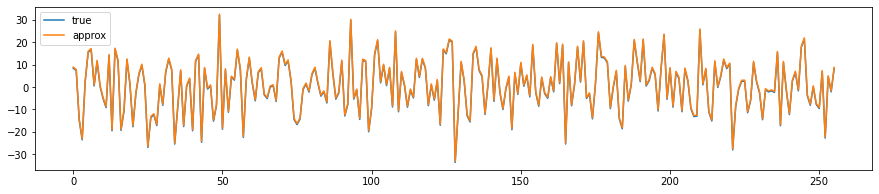

In [239]:
image = np.random.uniform(-1, 1, (1, 30, 30, 32))

ref = model3.layers[9](model3.layers[8](model3.layers[7](
    model3.layers[6](model3.layers[5](model3.layers[4](model3.layers[3](model3.layers[2](image)))))))
).numpy()[0]
test = M_a @ np.transpose(image, (0, 3, 1, 2)).flatten() + b_a
test = test ** 2
test = M_b @ test + b_b


plt.figure(figsize=(15, 3))
plt.plot(ref, label='true')
plt.plot(test + .45, label='approx')
plt.legend()
plt.show()

In [240]:
save_data(model3, name, linear=[(M_a.transpose(), b_a, 2, 5, True), (M_b.transpose(), b_b, 6, 10, True)])

(10, 2)


In [241]:
M_2.shape

(4096, 3200)

#### SV Decomposition

In [242]:
M_a_ = M_a.transpose()
M_a_.shape

(28800, 4096)

In [243]:
from sklearn.decomposition import NMF

In [244]:
model = NMF(n_components=32, init='random', random_state=0)
X = np.random.uniform(.1, 1, (1000, 256))
W = model.fit_transform(X)
H = model.components_

/home/han/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [245]:
W.shape
H.shape

(32, 256)

In [246]:
!pip3 install pip install pymf
!pip3 install pip install cvxopt

In [247]:
X = model3.layers[3].weights[0].numpy()
X = X.reshape(-1, X.shape[-1])
X.shape

(288, 64)

In [248]:
from sklearn.utils.extmath import randomized_svd
import random
from scipy.sparse.linalg import svds

n = 8
M = 32
N = 64
    
U, Sigma, VT = svds(X, k=n)

Sigma_ = np.zeros(shape=(n, n))
for i in range(n):
    Sigma_[i, i] = Sigma[i]

A = U @ Sigma_
B = VT

C = A @ B

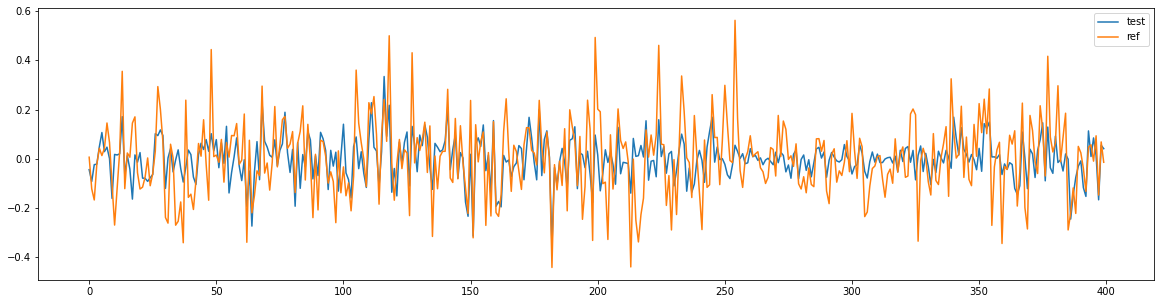

In [249]:
plt.figure(figsize=(20,5))
plt.plot(C.flatten()[:400], label='test')
plt.plot(X.flatten()[:400], label='ref')
plt.legend()
plt.show()

In [250]:
A = A.reshape(3, 3, M, n)
B = B.reshape(1, 1, n, N)

In [251]:
init1 = tf.constant_initializer(A)
init2 = tf.constant_initializer(B)

In [252]:
layers = cifar().layers
layers[3] = Conv2D(n, kernel_size=(3, 3), strides=1, kernel_initializer=init1)
layers.insert(4, Conv2D(N, kernel_size=(1, 1), strides=1, kernel_initializer=init2))
model_svd = Sequential(layers)
opt = Adam(lr=0.001)
model_svd.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [582]:
# model_svd.fit(
#     trainX, trainY,
#     epochs=200,
#     validation_data=(testX, testY),
#     workers=6,
#     batch_size=128
# )

model_svd = tf.keras.models.load_model('saved_model/CIFAR_SVD')

In [583]:
model_svd.save('saved_model/CIFAR_SVD')
model_svd.summary()
model_svd.evaluate(testX, testY)

INFO:tensorflow:Assets written to: saved_model/CIFAR_SVD/assets
Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_105 (Conv2D)          (None, 30, 30, 32)        896       
_________________________________________________________________
activation_69 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
average_pooling2d_46 (Averag (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 8, 8, 8)           2312      
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 8, 8, 64)          576       
_________________________________________________________________
dropout_46 (Dropout)         (None, 8, 8, 64)          0         
_______________________________________________________

[1.135678768157959, 0.7050999999046326]

In [584]:
W_conv = np.transpose(model_svd.layers[3].weights[0], (3, 2, 0, 1))
W_conv_biases = model_svd.layers[3].weights[1]

M_1 = conv_weights(d_in=30, W_c=avg_pool_weights(c_in=32, k=3), s=3, padding='same', pool=True)
M_2 = conv_weights(d_in=10, W_c=W_conv, s=1, padding='valid')

b_2 = conv_biases(d_in=10, W_c=W_conv, biases=W_conv_biases, s=1, padding='valid')

100%|██████████| 512/512 [00:00<00:00, 1832.13it/s]


In [585]:
M_a = M_2 @ M_1
b_a = b_2

In [586]:
M_a.shape

(512, 28800)

In [587]:
W_conv = np.transpose(model_svd.layers[8].weights[0], (3, 2, 0, 1))
W_conv_biases = model_svd.layers[8].weights[1]

M_3 = conv_weights(d_in=8, W_c=avg_pool_weights(c_in=64, k=2), s=2, padding='same', pool=True)
M_4 = conv_weights(d_in=4, W_c=W_conv, s=1, padding='valid')
M_5 = dense_weights(model_svd.layers[10].weights[0].numpy(), 256).transpose()

b_4 = conv_biases(d_in=4, W_c=W_conv, biases=W_conv_biases, s=1, padding='valid')
b_5 = model_svd.layers[10].weights[1].numpy()

100%|██████████| 1024/1024 [00:01<00:00, 942.00it/s]


In [588]:
M_b = M_5 @ M_4 @ M_3
b_b = M_5 @ b_4 + b_5

In [589]:
M_b.shape

(256, 4096)

In [590]:
save_data(model_svd, 'CIFAR_SVD', linear=[(M_a.transpose(), b_a, 2, 4, True), (M_b.transpose(), b_b, 7, 11, True)])

(11, 2)


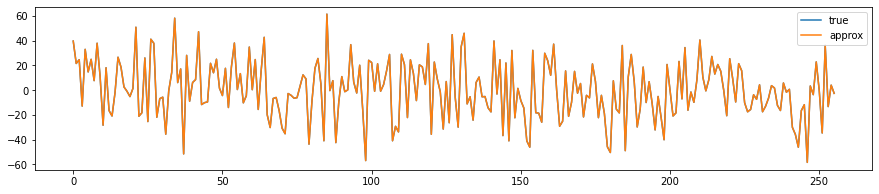

In [546]:
image = np.random.uniform(-1, 1, (1, 8, 8, 64))

a = model_svd.layers[10](model_svd.layers[9](model_svd.layers[8](model_svd.layers[7](image)))).numpy().flatten()
b = M_b @ (image.transpose((0, 3, 1, 2))).flatten() + b_b

plt.figure(figsize=(15, 3))
plt.plot(a, label='true')
plt.plot(b, label='approx')
plt.legend()
plt.show()


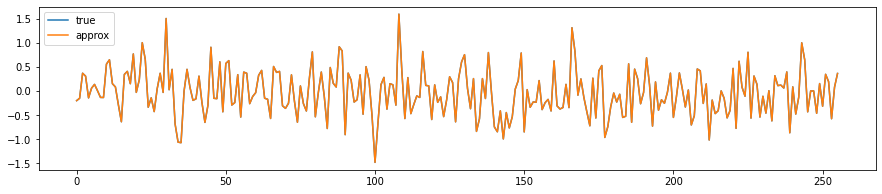

In [548]:
model_test = Sequential(
    model_svd.layers[0:11]
)

a = model_test(testX[8:8+1])[0].numpy().flatten()
b = np.load('256outputs.npy')

plt.figure(figsize=(15, 3))
plt.plot(a - b_b, label='true')
plt.plot(b[:256], label='approx')

plt.legend()
plt.show()


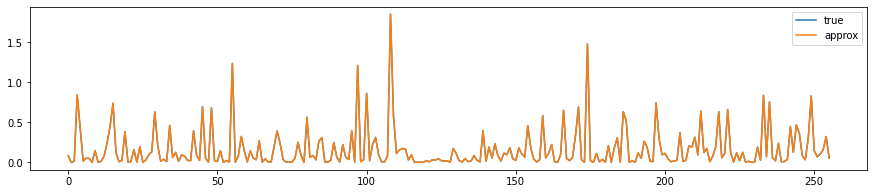

In [591]:
model_test = Sequential(
    model_svd.layers[0:12]
)

a = model_test(testX[8:8+1])[0].numpy().flatten()
b = np.load('256inputs.npy')

plt.figure(figsize=(15, 3))
plt.plot(a, label='true')
plt.plot(b[:256], label='approx')

plt.legend()
plt.show()

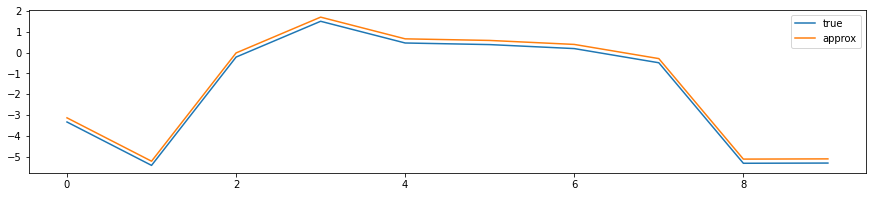

In [595]:
model_test = Sequential(
    model_svd.layers
)

model_test.layers[-1].activation = identity

a = model_test(testX[8:8+1])[0].numpy().flatten()
b = np.load('10outputs.npy')

plt.figure(figsize=(15, 3))
plt.plot(a, label='true')
plt.plot(b[:10] + .2, label='approx')

plt.legend()
plt.show()